# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button. Then continue scrolling until you cannot scroll anymore. The maximum number of images Google Images shows is 700.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

In [ ]:
from fastai import *
from fastai.vision import *

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [ ]:
folder = 'black'
file = 'urls_black.txt'

In [ ]:
folder = 'teddys'
file = 'urls_teddys.txt'

In [ ]:
folder = 'grizzly'
file = 'urls_grizzly.txt'

You will need to run this line once per each category.

In [ ]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![](images/download_images/upload.png)

## Download images

Now you will need to download you images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename and the destination folder and this function will download and save all images than can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [ ]:
download_images(path/file, dest, max_pics=200)

Good! Let's take a look at some of our pictures then.

In [ ]:
classes = ['teddys','grizzly','black']

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

teddys


grizzly


black


## View data

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

['black', 'grizzly', 'models', 'teddys']

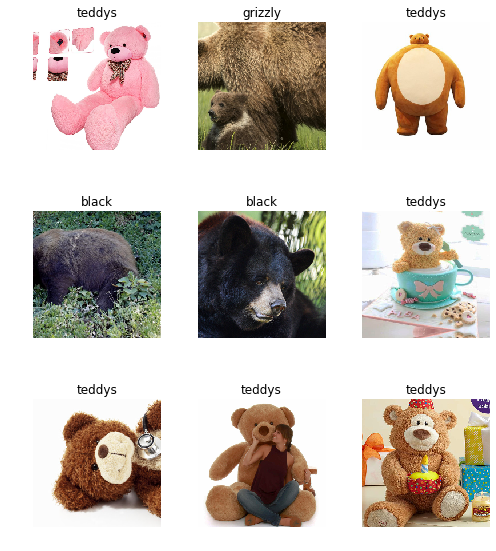

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'models', 'teddys'], 4, 473, 141)

## Train model

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)



In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


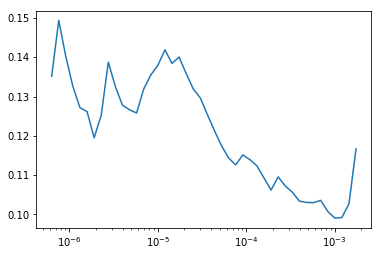

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

Total time: 00:28
epoch  train_loss  valid_loss  error_rate
1      0.117413    0.049618    0.014184    (00:13)
2      0.106041    0.055513    0.007092    (00:14)



In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

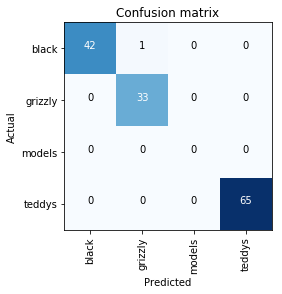

In [ ]:
interp.plot_confusion_matrix()

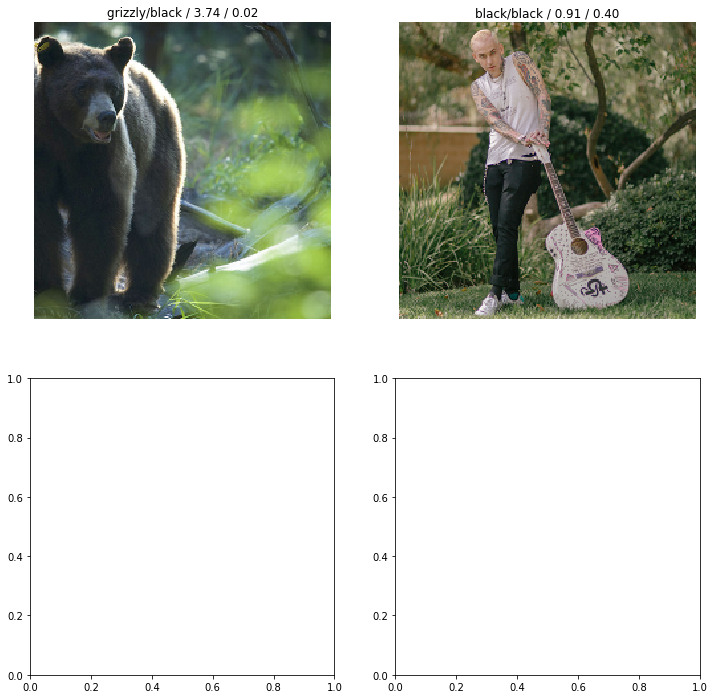

In [ ]:
interp.plot_top_losses(2)